# Hate Speech Detection Dataset exploration

## Import relevant libraries

In [81]:
import pandas as pd
import numpy as np
import sklearn
import nltk
nltk.download('stopwords') 
from collections import defaultdict, Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import operator
import matplotlib.pyplot as plt
import seaborn as sns


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rhysc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load the data

In [82]:
df_train = pd.read_csv('train_en.tsv', sep = '\t',index_col= 'id')
df_test = pd.read_csv('test_en.tsv', sep = '\t',header=None, index_col= 0)
df_dev = pd.read_csv('dev_en.tsv', sep = '\t', index_col= 'id')

In [83]:
df_train.head()

,text,HS,TR,AG
id,,,,
201,"Hurray, saving us $$$ in so many ways @potus @...",1,0,0
202,Why would young fighting age men be the vast m...,1,0,0
203,@KamalaHarris Illegals Dump their Kids at the ...,1,0,0
204,NY Times: 'Nearly All White' States Pose 'an A...,0,0,0
205,Orban in Brussels: European leaders are ignori...,0,0,0


In [84]:
df_train[df_train['TR'] == 1]

,text,HS,TR,AG
id,,,,
299,This immigrant should be hung or shot! Period!...,1,1,1
402,@eScarry @vdare https://t.co/aldUrQnEcUKathryn...,1,1,0
625,@RealKyleMorris @non99402819 Shut the fuck up ...,1,1,1
630,@KamalaHarris You are a Friggin idiot and ANTI...,1,1,1
709,#BuildThatWall #IllegalAliens @ICEgov .@EXPECT...,1,1,1
...,...,...,...,...
9189,@kimguilfoyle Does it bother you that Jrs kids...,1,1,0
9192,@CliffShep @MiaFarrow @realDonaldTrump Shut th...,1,1,1
9193,Happy Birthday you stupid fucking bitch. I hop...,1,1,1


In [85]:
#Check for missing values 
print('Training set missing data check : ', df_train.isna().sum())
print('Test set missing data check : ', df_test.isna().sum())
print('Dev set missing data check : ', df_dev.isna().sum())

Training set missing data check :  text    0
HS      0
TR      0
AG      0
dtype: int64
Test set missing data check :  1    0
2    0
3    0
4    0
dtype: int64
Dev set missing data check :  text    0
HS      0
TR      0
AG      0
dtype: int64


In [86]:
#As column names are not proper in test data set, rename them.
df_test.columns = ['text', 'HS', 'TR', 'AG']

In [87]:
# Check proportion of hate speech in each data set
print('Proportion of hate speech samples in training set : ', df_train[df_train['HS'] == 1].shape[0]/df_train.shape[0])
print('Proportion of hate speech samples in test set : ', df_test[df_test['HS'] == 1].shape[0]/df_test.shape[0])
print('Proportion of hate speech samples in dev set : ', df_dev[df_dev['HS'] == 1].shape[0]/df_dev.shape[0])


Proportion of hate speech samples in training set :  0.42033333333333334
Proportion of hate speech samples in test set :  0.4214069336923595
Proportion of hate speech samples in dev set :  0.427


In [88]:
# Many URLs are present
df_train.text.str.findall('https?:\/\/\S+').explode().dropna()

id
202     https://t.co/Ks0SHbtYqn
204     https://t.co/ACZKLhdMV9
204     https://t.co/CJAlSXCzR6
205     https://t.co/NeYFyqvYlX
208     https://t.co/D2mGu3VT5G
                 ...           
9144    https://t.co/Pb3m1cf85l
9149    https://t.co/t5For8SCow
9161    https://t.co/XWncjNWSIB
9169    https://t.co/oX2CZ6OO8C
9188    https://t.co/BsZO42LzqA
Name: text, Length: 4814, dtype: object

In [89]:
#Emoji s are present in the text.
df_train.text[6296]

'*Fires back* hoe ass bitch with a big ass forehead 😭 I knowwwwww 😭😭😭'

## Explore 'Hate Speech' and 'Not Hate speech' data seperately
To explore if any characteristics are different for tweets which are classified as 'Hate Speech' and as 'Not Hate Speech'. We are seperating the data set for exploration.

In [90]:
df_train_hs = df_train[df_train['HS'] == 1]
df_train_nhs = df_train[df_train['HS'] == 0]

The below histogram shows length of tweets.

1. It shows on an average we have 140 characters in a tweet.

2. Some of them have very small no: of characters (around 12 chars) and some are very lengthy (more than 300 chars)

In [91]:
full_ds_length = df_train.text.str.len()
hs_ds_length = df_train_hs.text.str.len()
nhs_ds_length = df_train_nhs.text.str.len()
print('Average no: of characters in the tweet (Full Data-set) - ',full_ds_length.mean())
print('Average no: of characters in the tweet (Hate speech Data) - ',hs_ds_length.mean())
print('Average no: of characters in the tweet (Not Hate speech Data) - ',nhs_ds_length.mean())

Average no: of characters in the tweet (Full Data-set) -  139.99844444444443
Average no: of characters in the tweet (Hate speech Data) -  142.58604282315622
Average no: of characters in the tweet (Not Hate speech Data) -  138.12210082422848


Text(0, 0.5, 'frequency')

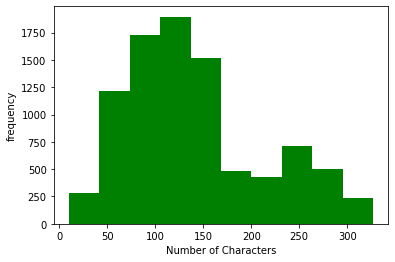

In [92]:
plt.hist(full_ds_length, color = 'green')
plt.xlabel('Number of Characters')
plt.ylabel('frequency')

As seen in the below histogram, we can see for the histograms for hate and not hate data have almost same shape. Frequencies are more for 'Not hate speech', may be because we have more data for 'Not hate speech'.

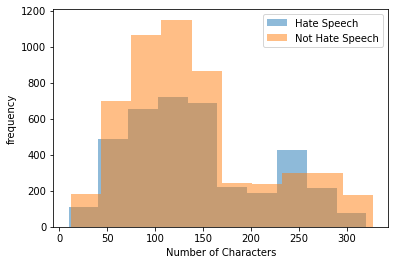

In [93]:
plt.hist(hs_ds_length, alpha=0.5, label='Hate Speech')
plt.hist(nhs_ds_length, alpha=0.5, label='Not Hate Speech')
plt.legend(loc='upper right')
plt.xlabel('Number of Characters')
plt.ylabel('frequency')
plt.show()

## T-Test
We will perform t-test to check if average no: characters in hate speech is significantly different from average no: of characters in not hate speech.

The obtained p-value is very small such that even at the significance level of alpha = 0.01, we can assume that they are significantly different. Hence it might be a good idea to add no: of features in the model

In [94]:
import scipy
scipy.stats.ttest_ind(hs_ds_length, nhs_ds_length)

Ttest_indResult(statistic=2.9720889682494995, pvalue=0.002965637902714289)

## Most frequent words in both the categories
Now we will explore most frequent words found in 'Not Hate Speech' data and 'Hate Speech' data.

In [95]:
most_common_hs = Counter(" ".join(df_train_hs["text"].str.lower()).split()).most_common(100)
most_common_nhs = Counter(" ".join(df_train_nhs["text"].str.lower()).split()).most_common(100)

<AxesSubplot:xlabel='Frequency', ylabel='Word'>

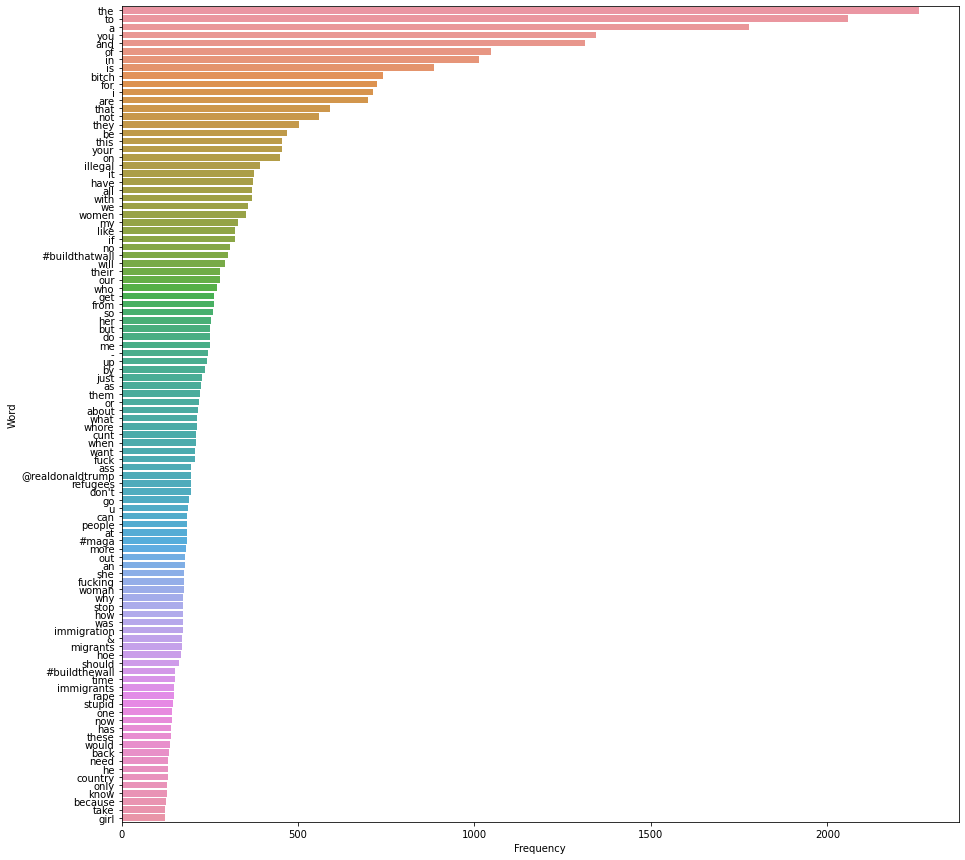

In [96]:
x, y= [], []
for word,count in most_common_hs[:100]:
    x.append(word)
    y.append(count)
plt.figure(figsize = (15,15))
plt.ylabel('Word')
plt.xlabel('Frequency')         
sns.barplot(x=y,y=x)

## Remove Stop Words
The above word frequency indicates that we need to remove stopwords to find interesting insights

In [97]:
sw = set(stopwords.words('english'))
# as removing the word - 'not' from text changes the context. We will keep it.
sw.remove('not')
# '-' is very frequent. We will add it to stopwords.
sw.add('-')


Below plot give some interesting insights.

1. Word like 'bitch' is very frequent in hate speech

2. Some words like -  'get', 'go', 'us', 'like' are shown in both category data. We can perform Ngram analysis to get insights on the context.

3. '&' can be replaced by 'and'. Thus it will be removed by stop words. 

<AxesSubplot:xlabel='frequency', ylabel='Word'>

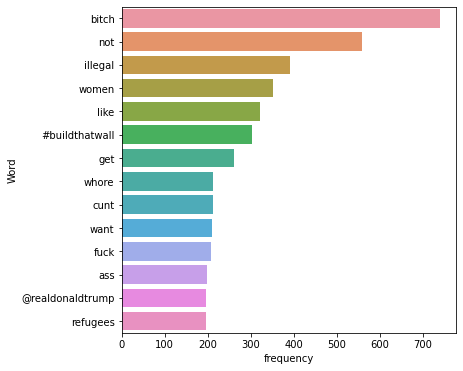

In [98]:
x, y= [], []
for word,count in most_common_hs[:60]:
  if (word.lower() not in sw):
    x.append(word)
    y.append(count)
plt.figure(figsize = (6,6))
plt.ylabel('Word')
plt.xlabel('frequency')       
sns.barplot(x=y,y=x)

<AxesSubplot:xlabel='frequency', ylabel='Word'>

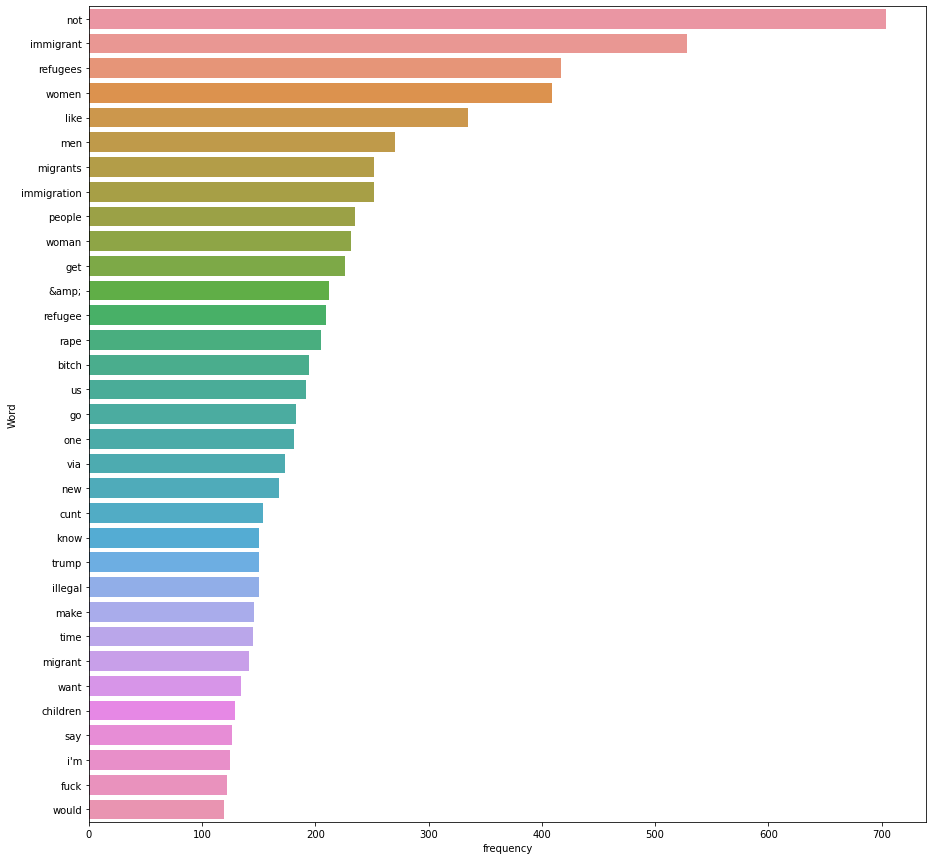

In [99]:
x, y= [], []
for word,count in most_common_nhs[:100]:
  if (word.lower() not in sw):
    x.append(word)
    y.append(count)
plt.figure(figsize = (15,15))  
plt.ylabel('Word')
plt.xlabel('frequency')          
sns.barplot(x=y,y=x)

## Ngram Analysis

In [100]:
hs_no_sw = df_train_hs.text.apply(lambda x: ' '.join([word.lower() for word in x.split() if word.lower() not in (sw)]))
nhs_no_sw = df_train_nhs.text.apply(lambda x: ' '.join([word.lower() for word in x.split() if word.lower() not in (sw)]))


Text(0.5, 0, 'frequency')

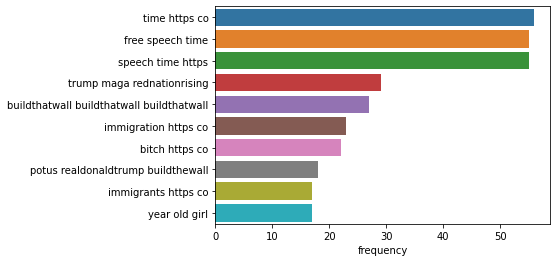

In [101]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]
top_n_bigrams=get_top_ngram(hs_no_sw,3)[:10]
x,y=map(list,zip(*top_n_bigrams))
   
sns.barplot(x=y,y=x)

plt.xlabel('frequency')

Text(0.5, 0, 'frequency')

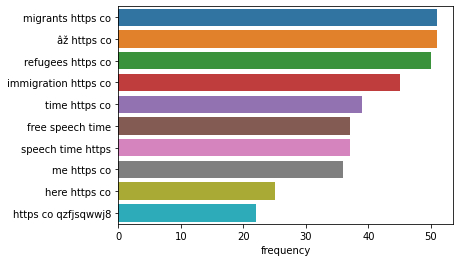

In [102]:
top_n_bigrams=get_top_ngram(nhs_no_sw,3)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

plt.xlabel('frequency')

'https co' is shown frequently. There are urls in many tweets.
We will remove them and perform Ngram analysis again.

In [103]:
hs_no_sw = hs_no_sw.str.replace('https?://[A-Za-z0-9./]+','')
nhs_no_sw = nhs_no_sw.str.replace('https?://[A-Za-z0-9./]+','')

Below trigram analysis shows 

1. 'buildthatwall', 'buildthewall' (same context but slight different word) are seen in Hate Speech.

2. 'free speech time', 'speech time isupport israel' are shown in both categories very frequently. 

Text(0.5, 0, 'frequency')

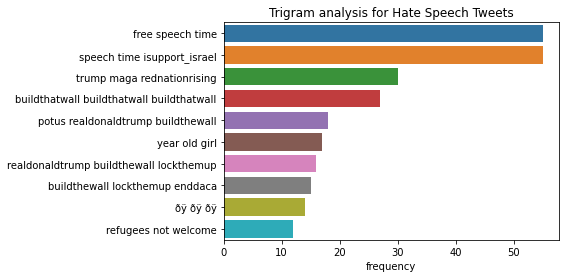

In [104]:
top_n_bigrams=get_top_ngram(hs_no_sw,3)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x).set_title('Trigram analysis for Hate Speech Tweets')
plt.xlabel('frequency')

Text(0.5, 0, 'frequency')

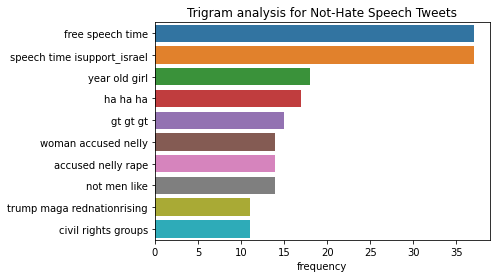

In [105]:
top_n_bigrams=get_top_ngram(nhs_no_sw,3)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x).set_title('Trigram analysis for Not-Hate Speech Tweets')
plt.xlabel('frequency')

In [106]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()
show_wordcloud(hs_no_sw)

ModuleNotFoundError: No module named 'wordcloud'

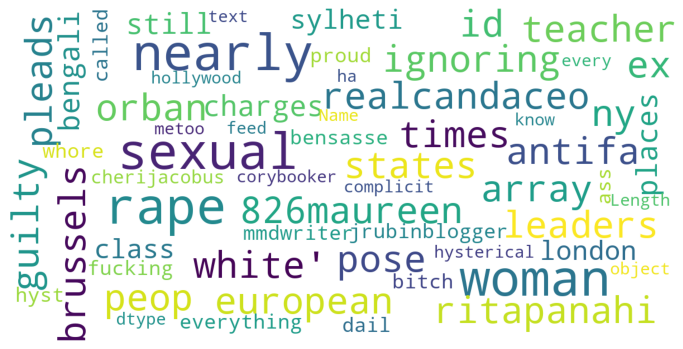

In [27]:
show_wordcloud(nhs_no_sw)

## Explore Test and validation Dataset

In [28]:
df_test_hs = df_test[df_test['HS'] == 1]
df_test_nhs = df_test[df_test['HS'] == 0]
df_dev_hs = df_dev[df_dev['HS'] == 1]
df_dev_nhs = df_dev[df_dev['HS'] == 0]

In [29]:
full_ds_length = df_test.text.str.len()
hs_ds_length = df_test_hs.text.str.len()
nhs_ds_length = df_test_nhs.text.str.len()
print('Average no: of characters in the tweet (Full test Data-set) - ',full_ds_length.mean())
print('Average no: of characters in the tweet (Hate speech test Data) - ',hs_ds_length.mean())
print('Average no: of characters in the tweet (Not Hate speech test Data) - ',nhs_ds_length.mean())
full_dev_length = df_dev.text.str.len()
hs_dev_length = df_dev_hs.text.str.len()
nhs_dev_length = df_dev_nhs.text.str.len()
print('Average no: of characters in the tweet (Full test Data-set) - ',full_dev_length.mean())
print('Average no: of characters in the tweet (Hate speech test Data) - ',hs_dev_length.mean())
print('Average no: of characters in the tweet (Not Hate speech test Data) - ',nhs_dev_length.mean())

Average no: of characters in the tweet (Full test Data-set) -  140.7728037697745
Average no: of characters in the tweet (Hate speech test Data) -  139.28194888178913
Average no: of characters in the tweet (Not Hate speech test Data) -  141.8586387434555
Average no: of characters in the tweet (Full test Data-set) -  157.632
Average no: of characters in the tweet (Hate speech test Data) -  159.46370023419203
Average no: of characters in the tweet (Not Hate speech test Data) -  156.2670157068063


In [30]:
most_common_hs = Counter(" ".join(df_test_hs["text"].str.lower()).split()).most_common(100)
most_common_nhs = Counter(" ".join(df_test_nhs["text"].str.lower()).split()).most_common(100)

In [31]:
scipy.stats.ttest_ind(hs_ds_length, nhs_ds_length)

Ttest_indResult(statistic=-0.8979444371291133, pvalue=0.36928798211671243)

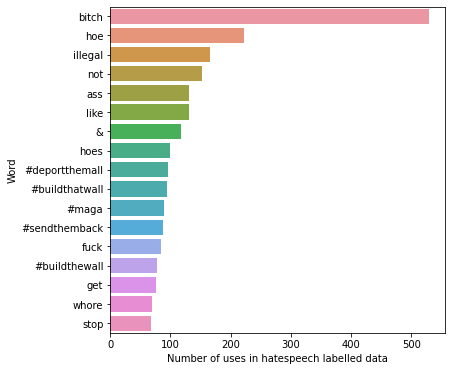

In [32]:
x, y= [], []
for word,count in most_common_hs[:60]:
    if (word.lower() not in sw):
        x.append(word)
        y.append(count)
plt.figure(figsize = (6,6)) 
plt.ylabel('Word')
plt.xlabel('Frequency')        
sns.barplot(x=y,y=x)

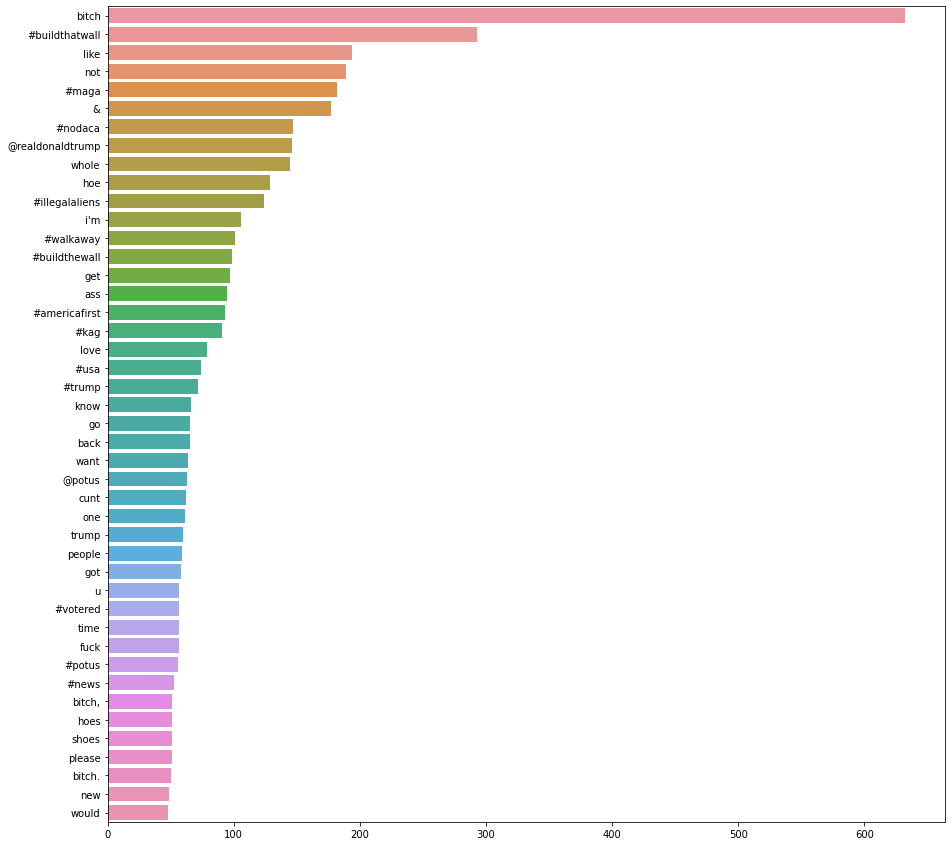

In [33]:
# Most common words in test dataset
x, y= [], []
for word,count in most_common_nhs[:100]:
    if (word.lower() not in sw):
        x.append(word)
        y.append(count)
plt.figure(figsize = (15,15))        
sns.barplot(x=y,y=x)
plt.ylabel('Word')
plt.xlabel('frequency')

In [34]:
most_common_dev_hs = Counter(" ".join(df_dev_hs["text"].str.lower()).split()).most_common(100)
most_common_dev_nhs = Counter(" ".join(df_dev_nhs["text"].str.lower()).split()).most_common(100)

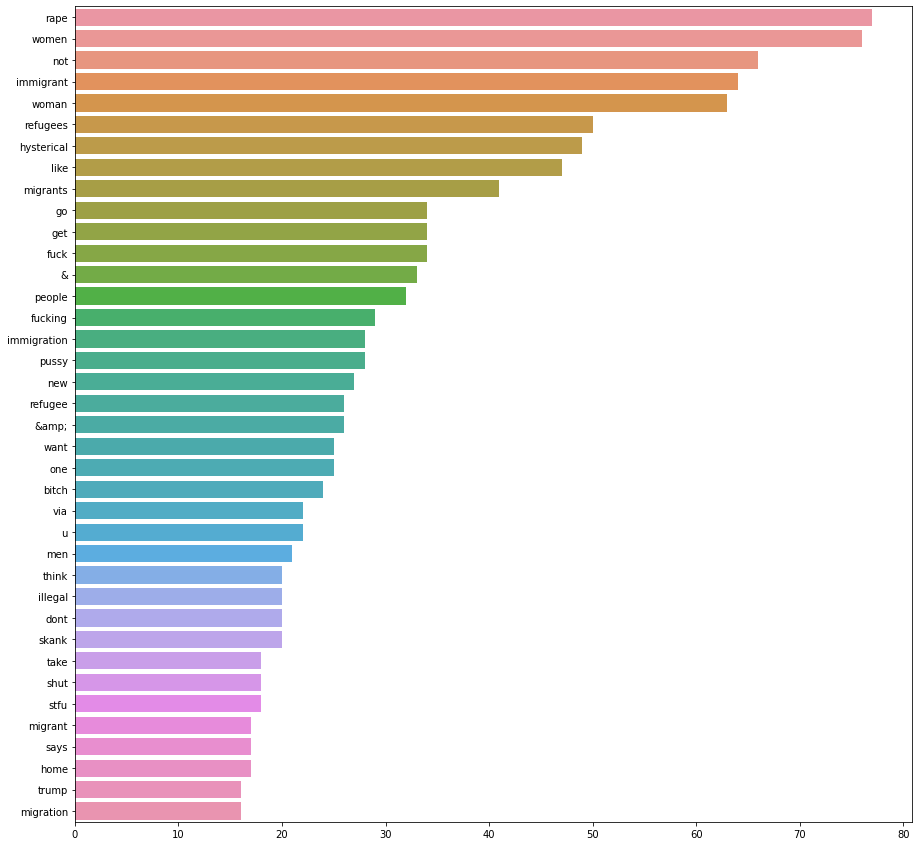

In [35]:
# Most common words in validation data set
x, y= [], []
for word,count in most_common_dev_nhs[:100]:
    if (word.lower() not in sw):
        x.append(word)
        y.append(count)
plt.figure(figsize = (15,15))        
sns.barplot(x=y,y=x)
plt.ylabel('Word')
plt.xlabel('frequency')